In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [25]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/tmp_linreg_corr_init"
#dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
dsc_fname = "linreg_corr_init"
db = os.path.join(dsc_output, dsc_fname + ".db")

print(db)

/home/saikatbanerjee/scratch/work/gradvi-experiments/tmp_linreg_corr_init/linreg_corr_init.db


In [26]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [27]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table
qp_df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1
1,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_1_lasso_1_mr_ash_l...
2,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",gradvi_direct,gradvi_direct/blockdiag_1_gradvi_direct_1
3,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",gradvi_compound,gradvi_compound/blockdiag_1_gradvi_compound_1
4,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",gradvi_direct_lasso_init,gradvi_direct_lasso_init/blockdiag_1_lasso_1_g...
5,1,blockdiag,5,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_1_lasso_1...


In [29]:
data = dsc_io.load_dsc(os.path.join(dsc_output, f"{qp_df['simulate.output.file'].values[0]}.pkl"))

In [30]:
data['beta'][np.where(data['beta']!=0)[0]]

array([-0.20090776,  0.03409952,  0.49035118,  0.42523984,  0.29276397])

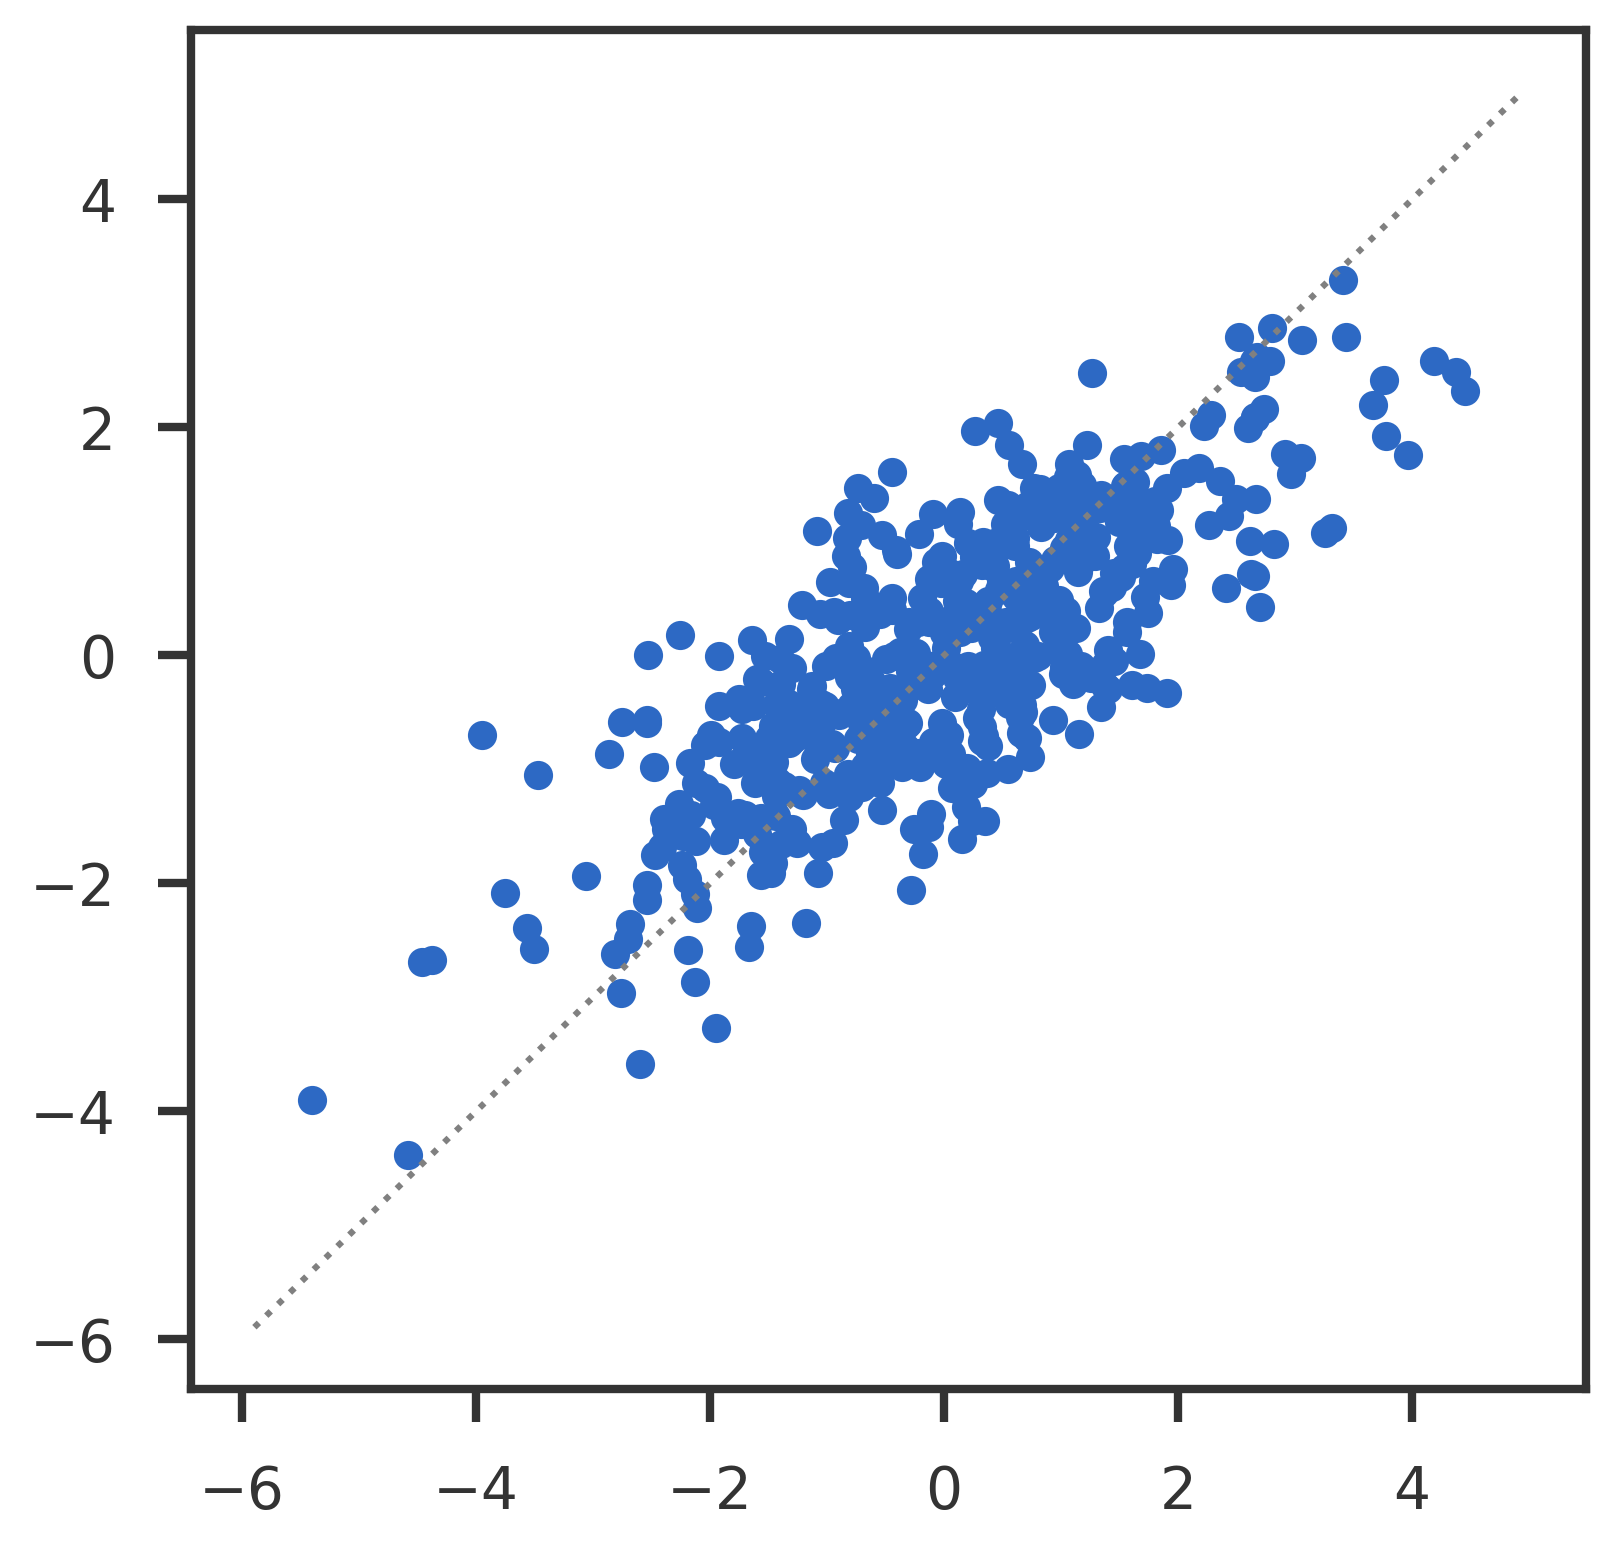

In [31]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data['y'], np.dot(data['X'], data['beta']))
mpl_utils.plot_diag(ax1)
plt.show()

In [32]:
methods = qp_df['fit'].unique()

In [33]:
def read_dsc_result(df, method):
    dfm = stratify_dfcol(df, "fit", method)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    res = dsc_io.load_dsc(fname)
    return res

resdict = dict()
for method in methods:
    resdict[method] = read_dsc_result(qp_df, method)

In [35]:
for method, res in resdict.items():
    ypred = np.dot(data['Xtest'], res['beta_est'])
    rmse = np.sqrt(np.mean(np.square(data['ytest'] - ypred)))
    #bpred = res['beta_est']
    #rmse = np.sqrt(np.mean(np.square(data['beta'] - bpred)))
    print(method, rmse)

mr_ash 1.887893388905236
mr_ash_lasso_init 1.9342743363500725
gradvi_direct 1.0361910177624651
gradvi_compound 1.0161772721035045
gradvi_direct_lasso_init 1.0116264371459784
gradvi_compound_lasso_init 0.9937992354267645


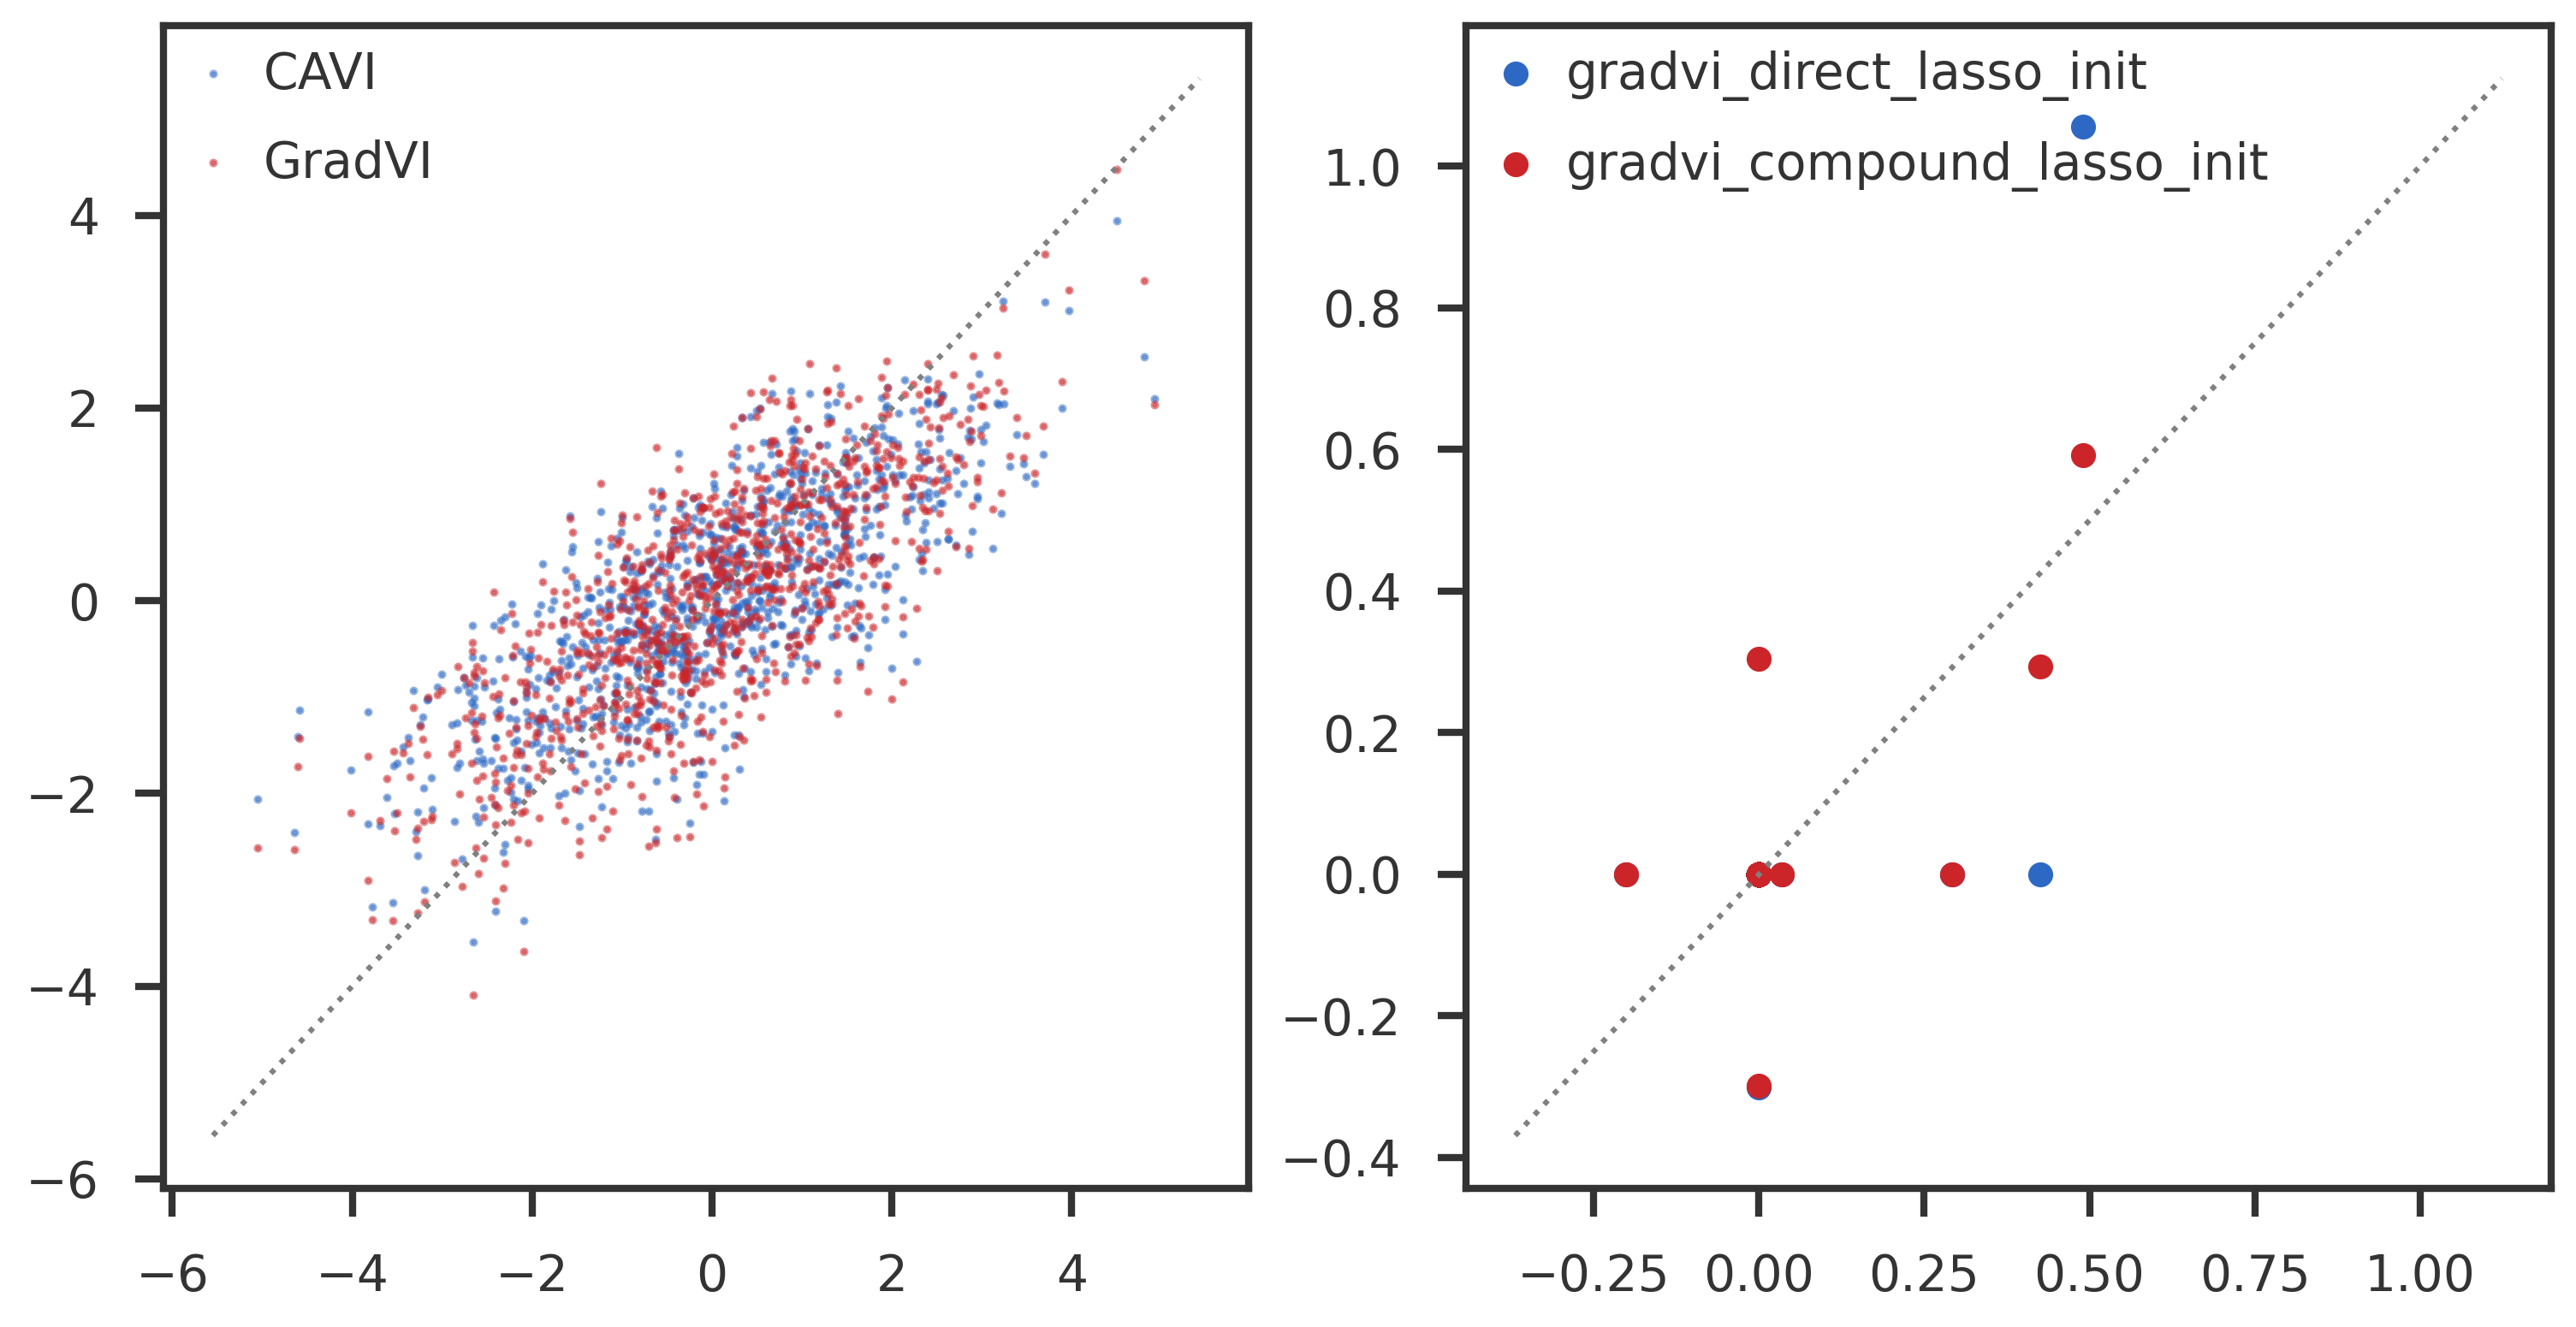

In [48]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(data['ytest'], np.dot(data['Xtest'], resdict['mr_ash']['beta_est']), 
            label = 'CAVI', alpha = 0.5, s = 2)
ax1.scatter(data['ytest'], np.dot(data['Xtest'], resdict['gradvi_compound_lasso_init']['beta_est']),
            label = 'GradVI', alpha = 0.5, s = 2)


for method in methods[4:]:
    ax2.scatter(data['beta'], resdict[method]['beta_est'], label = method)
    
mpl_utils.plot_diag(ax2)
ax2.legend()

ax1.legend()
mpl_utils.plot_diag(ax1)
plt.show()

In [42]:
def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]

for method, res in resdict.items():
    elbo = get_elbo_from_result(res, method)
    print(method, elbo)

mr_ash 743.2945178182325
mr_ash_lasso_init 711.8802386387671
gradvi_direct 736.5395973214181
gradvi_compound 710.3663074241413
gradvi_direct_lasso_init 718.2776503770438
gradvi_compound_lasso_init 717.4414593025358


In [43]:
resdict['gradvi_compound_lasso_init']['model']['prior']

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.03526492, 0.07177346, 0.10956947, 0.14869835,
        0.18920712, 0.23114441, 0.27456063, 0.31950791, 0.36604026,
        0.41421356, 0.4640857 , 0.51571657, 0.5691682 , 0.62450479,
        0.68179283, 0.74110113, 0.80250093, 0.86606598, 0.93187266]),
 'w': array([9.99478432e-01, 1.67953441e-09, 1.67912080e-09, 1.67898033e-09,
        1.67942702e-09, 9.35391390e-07, 5.19885520e-04, 7.20012547e-07,
        1.87308857e-09, 1.68199887e-09, 1.68252492e-09, 1.68290404e-09,
        1.68313321e-09, 1.68323870e-09, 1.68324910e-09, 1.68318997e-09,
        1.68308206e-09, 1.68294145e-09, 1.68278015e-09, 1.68260695e-09]),
 'wmod': array([  1.78334269, -18.42088483, -18.42113112, -18.42121478,
        -18.42094877, -12.0984364 ,  -5.77803753, -12.3601328 ,
        -18.31181273, -18.41941855, -18.41910585, -18.41888055,
        -18.41874438, -18.41868171, -18.41867553, -18.41871066,
        -18.41877477, -18.41885831, -18.41895416, -18.41905

In [44]:
resdict['gradvi_compound']['model']['prior']

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.03526492, 0.07177346, 0.10956947, 0.14869835,
        0.18920712, 0.23114441, 0.27456063, 0.31950791, 0.36604026,
        0.41421356, 0.4640857 , 0.51571657, 0.5691682 , 0.62450479,
        0.68179283, 0.74110113, 0.80250093, 0.86606598, 0.93187266]),
 'w': array([9.99780310e-01, 8.25013032e-16, 2.02539442e-11, 1.47914455e-09,
        1.23879731e-08, 4.56629453e-08, 1.01184935e-07, 1.52551770e-07,
        1.83731553e-07, 2.09312914e-07, 2.53006024e-07, 3.41955380e-07,
        5.25259570e-07, 9.20619695e-07, 1.84733966e-06, 4.25838978e-06,
        1.11928027e-05, 3.16508875e-05, 7.55349389e-05, 9.24583545e-05]),
 'wmod': array([ 12.10558384, -22.62532894, -12.51686801,  -8.22599837,
         -6.10073619,  -4.79617514,  -4.0005124 ,  -3.58995827,
         -3.40398654,  -3.27363195,  -3.08404898,  -2.78278202,
         -2.35356972,  -1.79241526,  -1.09596042,  -0.2608159 ,
          0.70556396,   1.74505919,   2.61488831,   2.81705

In [45]:
bidx = np.where(data['beta']!=0)[0]
for method, res in resdict.items():
    #ypred = np.dot(data['Xtest'], res['beta_est'])
    bpred = res['beta_est']
    #rmse = np.sqrt(np.mean(np.square(data['ytest'] - ypred)))
    rmse = np.sqrt(np.mean(np.square(data['beta'] - bpred)))
    print(method, rmse)
    print(bpred[bidx])

mr_ash 0.007407530728097481
[[-0.00014061]
 [ 0.00012639]
 [ 0.00378229]
 [ 0.00080734]
 [ 0.00035001]]
mr_ash_lasso_init 0.012682607219659147
[[-9.88044153e-05]
 [ 4.16812717e-05]
 [ 1.02963903e+00]
 [ 1.09976169e-04]
 [ 3.88412633e-05]]
gradvi_direct 0.01103498453266478
[-9.64211637e-05  8.03864134e-05  8.46764573e-04  2.54097757e-04
  9.57072316e-05]
gradvi_compound 0.009027015635832742
[2.17176578e-07 2.16359911e-06 1.13137629e+00 1.15824490e-05
 1.59285943e-06]
gradvi_direct_lasso_init 0.00847597433789154
[-8.06496398e-07  1.49071110e-05  1.05596370e+00  2.18102666e-04
  2.15620925e-05]
gradvi_compound_lasso_init 0.005808137956292057
[-5.69383332e-07  2.68347614e-05  5.91694877e-01  2.92921683e-01
  1.22438027e-06]


In [46]:
data['beta'][bidx]

array([-0.20090776,  0.03409952,  0.49035118,  0.42523984,  0.29276397])